## Import Libaries

In [2]:
import locale

In [3]:
!pip install -U transformers
!pip install wandb
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=facc3e47b82cc3b5394730e1120a2b3ee96195389fcfae475393683a9176bc55
  Stored in directory: /root/.cache/pip/wheels

In [4]:
import re
import spacy
import nltk, string
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import warnings, torch
import tensorflow as tf
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelWithLMHead
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Wand login for loggin loss

In [5]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load the dataset

In [6]:
# load the preprocessed dfset
df = pd.read_csv('preprocessed_emotion_dataset_letest.csv')
df.drop(['tweet'], axis=1,inplace=True)
display(df.head())

,clean_tweet,emotion
0,time ticking fast relive past happy joy face,happy
1,happy birthday one hot love much amazing frien...,happy
2,best cheer left min cant save happy like treas...,happy
3,good morning wishing day filled sunshine happi...,happy
4,eric movie made happy several way think rely s...,happy


## Convert categories of label into numbers

In [7]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = pd.DataFrame(label_encoder.fit_transform(df.emotion))
print(df.label.unique())
df.head()

[3 4 0 2 1 5]


,clean_tweet,emotion,label
0,time ticking fast relive past happy joy face,happy,3
1,happy birthday one hot love much amazing frien...,happy,3
2,best cheer left min cant save happy like treas...,happy,3
3,good morning wishing day filled sunshine happi...,happy,3
4,eric movie made happy several way think rely s...,happy,3


In [8]:
# create label to numeric map
label_map = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise"}

In [9]:
# read the other emotion dataset
temp = pd.read_csv("output_train_lemmatize.csv", header=None)
temp.head()

,0
0,didnt feel humiliated sadness
1,go feeling hopeless damned hopeful around some...
2,im grabbing minute post feel greedy wrong anger
3,ever feeling nostalgic fireplace know still pr...
4,feeling grouchy anger


In [10]:
# preprocess the dataset
t = []
for text in temp.iloc[:, 0]:
  label = text.split()[-1]
  if label != "love":
    t.append((text[:-(len(label)+1)], label, len(text[:-len(label)])))


new_df = pd.DataFrame(t)
new_df.columns = ['clean_tweet', 'emotion', 'label']
l1 = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}


new_df = new_df.replace("surpris", "surprise")
new_df = new_df.replace("anger", "angry")
new_df = new_df.replace("joy", "happy")
new_df = new_df.replace("sadness", "sad")
new_df['label'] = new_df.emotion.replace(l1)
new_df['label'].value_counts()

# df.emotion.value_counts()
df_final = pd.concat([df, new_df], axis=0)
print(df_final.shape)
df_final.head()

(22408, 3)


,clean_tweet,emotion,label
0,time ticking fast relive past happy joy face,happy,3
1,happy birthday one hot love much amazing frien...,happy,3
2,best cheer left min cant save happy like treas...,happy,3
3,good morning wishing day filled sunshine happi...,happy,3
4,eric movie made happy several way think rely s...,happy,3


In [11]:
df_final.emotion.value_counts()

happy       8459
sad         6924
angry       3127
fear        2522
surprise     826
disgust      550
Name: emotion, dtype: int64

## Plot Histrogram of length of tweet

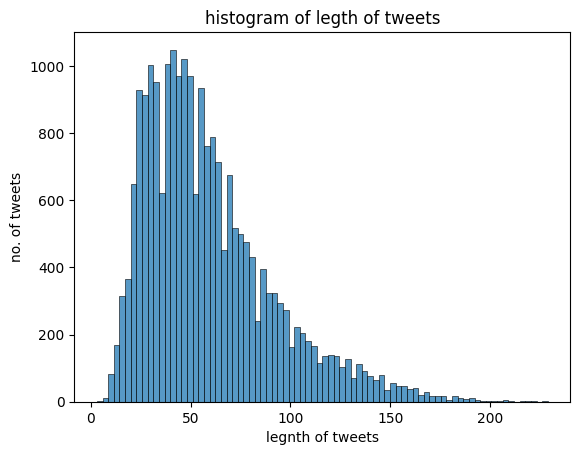

In [13]:
# plot histogram of tweet legnth
length_list = []
for sent in df_final.clean_tweet:
  length_list.append(len(sent))


sns.histplot(length_list)
plt.title("histogram of legth of tweets")
plt.ylabel("no. of tweets")
plt.xlabel("legnth of tweets")
plt.show()

## Extract POS tags for each tweet and concat with original tweet text


In [14]:
np.mean(np.array(length_list))

59.22768654052124

In [18]:
# select feature asn labels
# _pos.tweet_with_pos.tolist()
x = df_final.clean_tweet.tolist()
y = list(df_final.label)

## Split the dataset

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21, stratify=y)

## Created Pytorch Dataset for Bert model

In [21]:
import torch


# function to evaluate test set
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

## **Bert model Training, Prediction and Saving**

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda")
print(device)


# initialize model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model1 = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6).to(device)


# get bert tokens embeddings from tweet 
x_train_tokenized = tokenizer(x_train, padding=True, truncation=True, max_length=150)
x_test_tokenized = tokenizer(x_test, padding=True, truncation=True, max_length=150)


# convert token embedding to Pytorch Dataset
train_dataset = Dataset(x_train_tokenized, y_train)
test_dataset = Dataset(x_test_tokenized, y_test)


# set training arguments
args = TrainingArguments(num_train_epochs=8,
                         output_dir="./output",
                         warmup_steps=500,
                         evaluation_strategy="steps",
                         per_device_train_batch_size=64,
                         per_device_eval_batch_size=64,
                         weight_decay=0.01,
                         logging_dir='./logs',
                         logging_steps=500,
                         eval_steps=500,
                         report_to='wandb',
                         run_name='bert-base-cased')



# intialize Trainer 
trainer = Trainer(model=model1,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  compute_metrics=compute_metrics)



# train and test model
trainer.train()
wandb.finish()



# save model
trainer.save_model("/content/drive/MyDrive/IR project/model/bert_base_cased")
print("model saved")

cuda


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.695600,0.241951,0.923695,0.925048,0.923695,0.922925
1000,0.163500,0.234054,0.927265,0.928245,0.927265,0.927575
1500,0.074100,0.305094,0.933512,0.934656,0.933512,0.933638
2000,0.032300,0.315905,0.932619,0.933621,0.932619,0.932764


<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>
<class 'transformers.trainer_utils.EvalPrediction'>


eval/accuracy,▁▄█▇
eval/f1,▁▄█▇
eval/loss,▂▁▇█
eval/precision,▁▃█▇
eval/recall,▁▄█▇
eval/runtime,▁█▇▃
eval/samples_per_second,█▁▂▆
eval/steps_per_second,█▁▂▆
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


model saved


## **Load saved model and Predict the Emotion for New Tweet**

In [28]:
saved_model1 = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/IR project/model/bert_base_cased', num_labels=6).to(device)

In [31]:
# inference code
text = input("Enter the tweet text : ")
encoding1 = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
encoding1 = {k: v.to(trainer.model.device) for k,v in encoding1.items()}


outputs = saved_model1(**encoding1)
label = torch.argmax(outputs['logits']).item()
print(label_map[label])

Enter the tweet text : I was fuming when my colleague interrupted me in the middle of my presentation
angry


In [ ]:
# I was fuming when my colleague interrupted me in the middle of my presentation
# janak is a studious funny interesting guy